In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subtractr
import subtractr.utils as util
import os

## Spatial cell estimation
1. Load results after running photocurrent subtraction + demixing + caviar
2. use the average photocurrent estimates to estimate the patched cell location 

In [2]:
example_path = '../figures/full_pipeline/spatial_analysis/220308_B6_Chrome2fGC8_030822_Cell1_OpsPositive_A_planes_cmReformat_with_nws_results.npz'
results = np.load(example_path, allow_pickle=True)
results = util.sort_results(results)

(3380, 3)


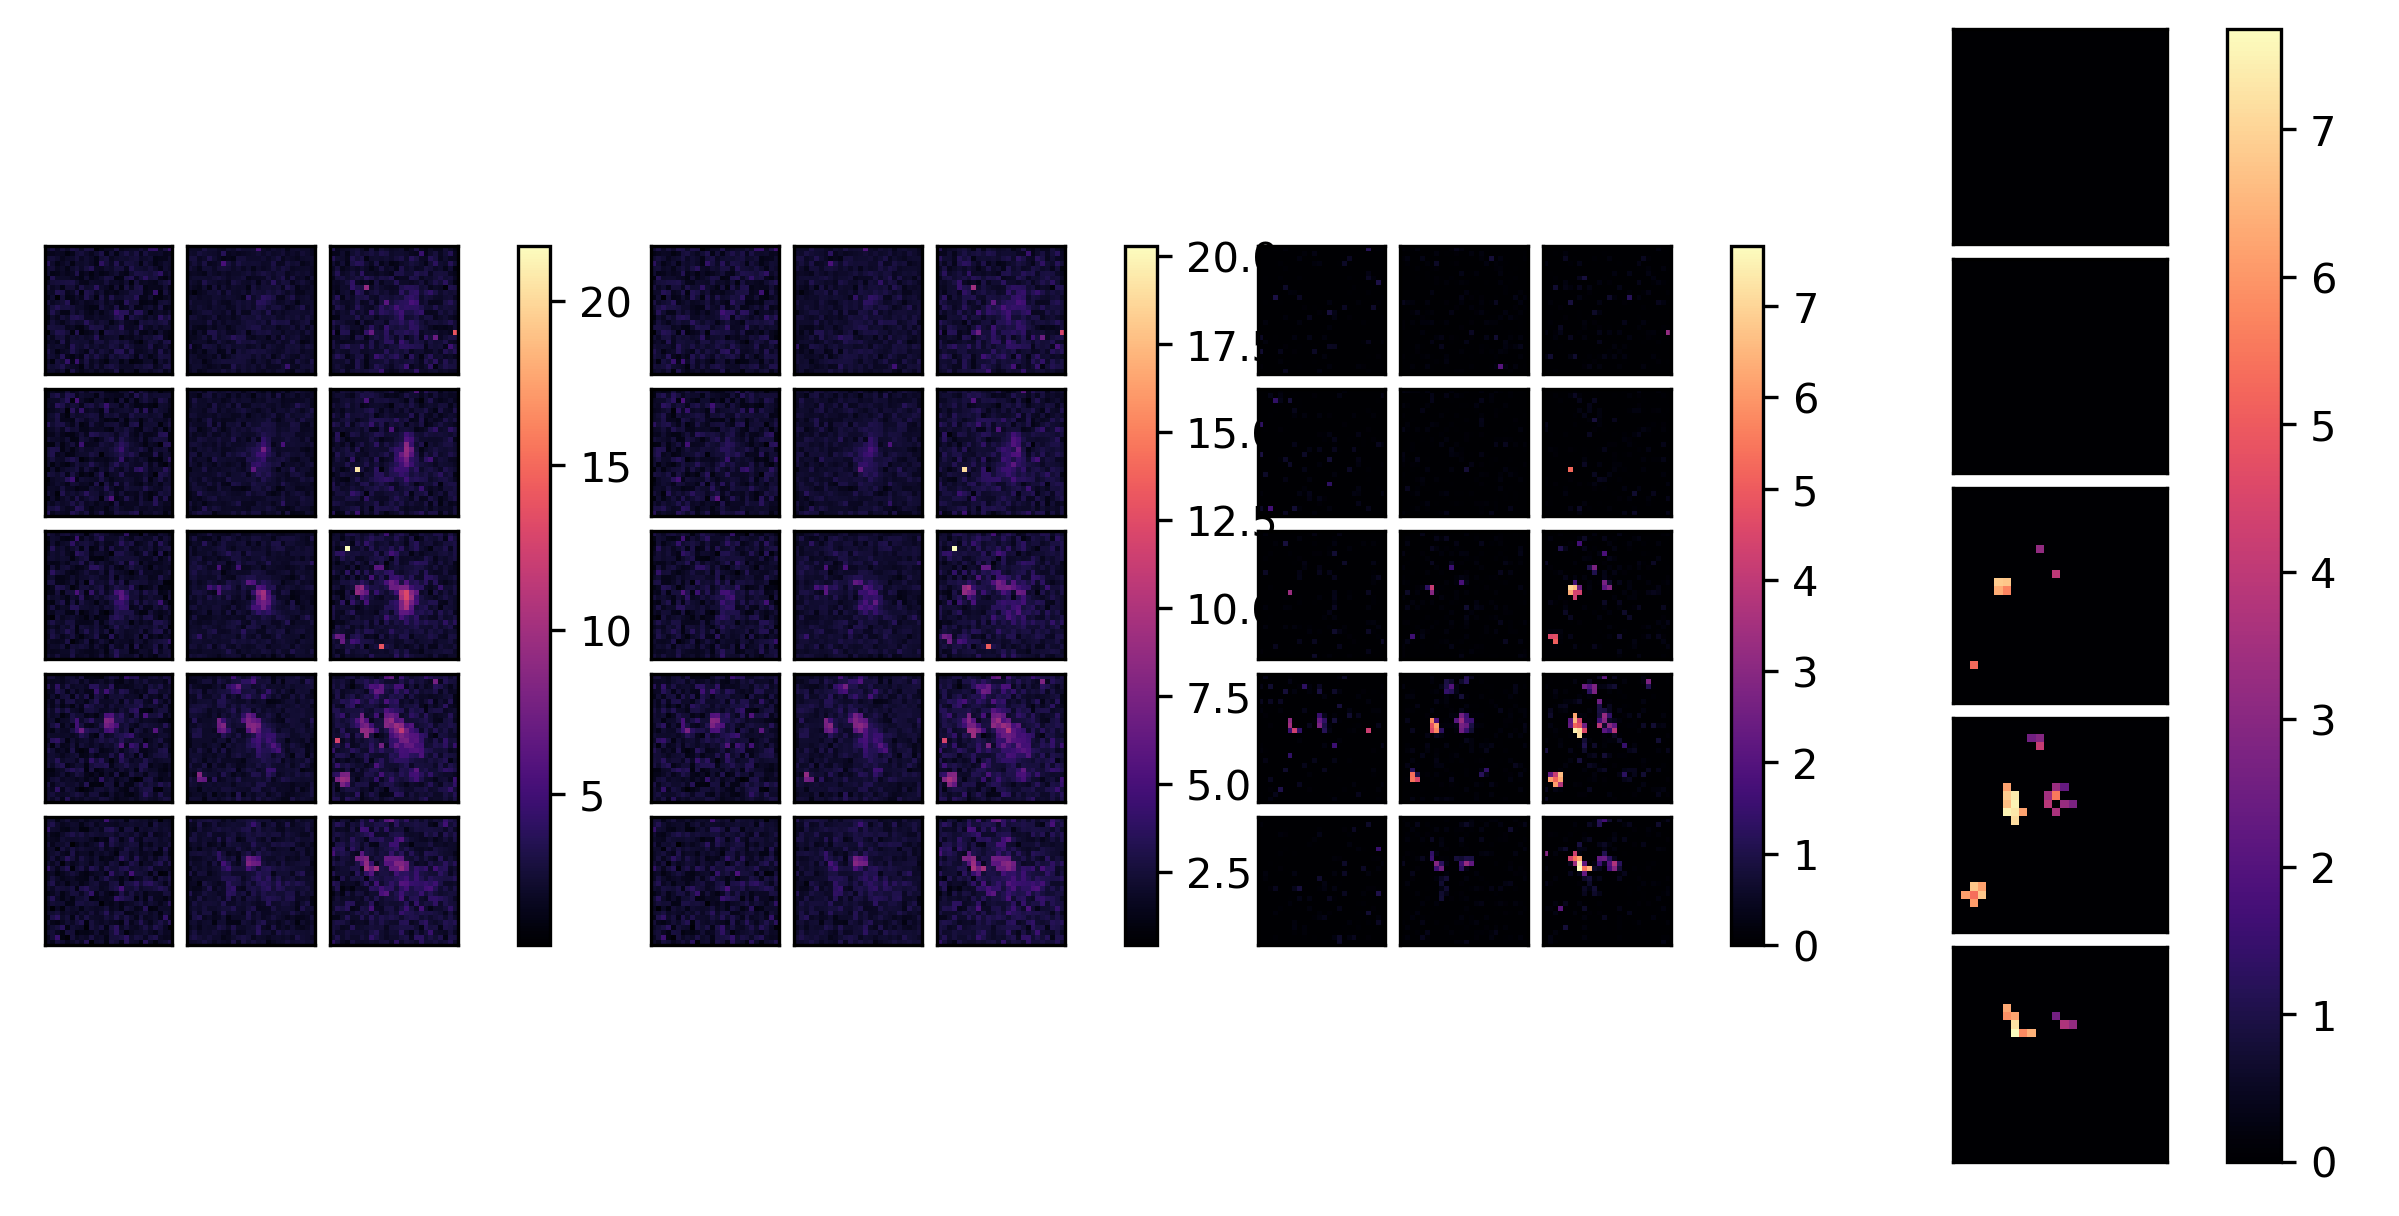

In [3]:
fig = plt.figure(figsize=(10,5), dpi=300)
est_map = util.traces_tensor_to_map(results['est_tensor'])
weights_map = results['model_state']['mu'].reshape(1, *est_map.shape[1:])
util.plot_multi_means(
    fig,
    [results['raw_map'], results['subtracted_map'], results['demixed_map'], weights_map],
    np.arange(5),
    cmaps=['magma', 'magma', 'magma', 'magma'],
)


## Aggregate across experiments
for each experiment
    1. compute center of mass
    3. convert center of mass to imaging coordinates from index coordinates
    2. subtract center of mass from targets
    
output data structure which is a dictionary:
```
{
    filepath: {
        'targets': targets,
        'com': estimated_com in imaging coordinates
        'weights': caviar weights
        'raw obs': average observation (before subtraction + demixing) at that pixel
        }
}
```

In [4]:
from scipy import ndimage

In [31]:
filenames = [
'220308_B6_Chrome2fGC8_030822_Cell1_OpsPositive_A_planes_cmReformat_with_nws_results.npz',
'220308_B6_Chrome2fGC8_030822_Cell2_opsPositive_A_planes_cmReformat_with_nws_results.npz',
'220314_WT_Chrome2fGC8_IV_031422_MultispotGrid_Cell3_opsPositive_A_planes_cmReformat_with_nws_results.npz',
'220617_B6_Chrome2fGC8_IC_061722_Cell1_C_planes_cmReformat_with_nws_results.npz',
'220704_B6_Chrome2fGC8_IC_070422_Cell1_Control_A_planes_cmReformat_with_nws_results.npz',
]

top_level_path = '../figures/full_pipeline/spatial_analysis/'

def index_coords_to_image_coords(index_pt, targets):
    '''
    Converts a point in pixel coordinates to um
    '''

    # conversion from index coords to image coords
    # is a linear transform img_x = a*idx_x + b
    # We perform the same transform for x,y,z
    img_pt = np.zeros_like(index_pt)
    for i, coord in enumerate(index_pt):
        unique_tars = np.unique(targets[:,i])
        b = unique_tars[0]
        
        # handle the case where there is only a single z plane
        if len(unique_tars) == 1:
            a = 0
        else:
            a = unique_tars[1] - unique_tars[0]
        img_pt[i] = a*coord + b

    return img_pt

def align_experiments_by_planes(photocurrent_estimate_map, targets, power_idx=-1):
    """
    Aligns the targets to the center of mass of the photocurrent estimate map,
    for each plane.

    args:
        photocurrent_estimate_map: (num_powers x num_x x num_y x num_z)
        targets: (num_targets x 3) array of target coordinates
        power_idx: index of power to use for alignment
    returns:
        aligned_targets: (num_targets x 3) array of aligned target coordinates
    """
    aligned_targets = np.copy(targets)
    zs = np.unique(targets[:,2])
    num_zs = len(zs)
    for plane_idx in range(num_zs):

        # get center of mass of this plane in pixel coords,
        # then convert to image coords
        this_plane = photocurrent_estimate_map[power_idx,:,:,plane_idx]
        com_pixel_coords = ndimage.center_of_mass(this_plane)
        com_img_coords = index_coords_to_image_coords(com_pixel_coords, targets)
        
        # now shift targets corresponding to the current plane
        # so that the center of mass is at the origin
        these_target_idxs = (targets[:,2] == zs[plane_idx])
        aligned_targets[these_target_idxs, 0:2] -= com_img_coords
    return aligned_targets



In [32]:
aggregated_results = {}
for file in filenames:
    loadpath = os.path.join(top_level_path, file)
    results = np.load(loadpath, allow_pickle=True)
    results = util.sort_results(results)
    est_map = util.traces_tensor_to_map(results['est_tensor'])

    aligned_targets = align_experiments_by_planes(est_map, results['targets'])
    weights = results['model_state']['mu']
    
    aggregated_results[os.path.basename(file)] = dict(
        aligned_targets = aligned_targets,
        weights = weights,
    )
    
    

(3380, 3)
(3380, 3)
(676, 3)
(3380, 3)
(3380, 3)


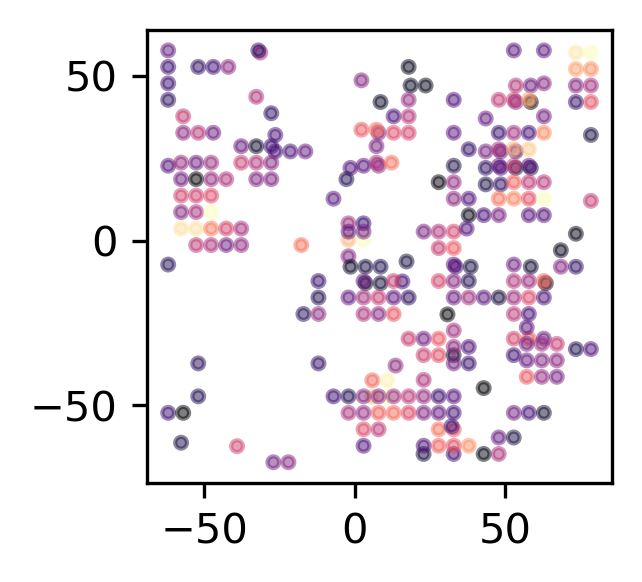

In [38]:
keys = list(aggregated_results.keys())
plt.figure(figsize=(2,2), dpi=300)
for key in keys:
    
    results = aggregated_results[key]
    # Get number of planes
    unique_zs = np.unique(results['aligned_targets'][:,2])

    # find index for the middle plane
    middle_plane_idx = int(len(unique_zs)/2)
    middle_plane_coordinate = np.unique(results['aligned_targets'][:,2])[middle_plane_idx]
    
    # get the targets in the middle plane
    middle_plane_idxs = (results['aligned_targets'][:,2] == middle_plane_coordinate)
    middle_plane_targets = results['aligned_targets'][middle_plane_idxs, 0:2]
    middle_plane_weights = results['weights'][middle_plane_idxs]
    nonzero_idxs = (middle_plane_weights > 0)

    # scatter plot the nonzero weights for the current plane, 
    # where the color is the weight
    plt.scatter(middle_plane_targets[nonzero_idxs,0],
        middle_plane_targets[nonzero_idxs,1],
        c=middle_plane_weights[nonzero_idxs],
        cmap='magma',
        alpha=0.5,
        s=8,
    )

    

## Sanity check #1: make sure that COM estimates look reasonable
To estimate a 2D center of mass given our 3D datasets, we'll first sum over the Z dimension, then use
`ndimage.center_of_mass`

In [87]:

# Loop over each dataset. For each dataset, sum across the Z dimension to get a 2D map
# then make a scatter plot of the weights with the estimated COM marked
twod_results = {}
for i, file in enumerate(filenames):
    loadpath = os.path.join(top_level_path, file)
    results = np.load(loadpath, allow_pickle=True)
    results = util.sort_results(results)

    # Form estimate of photocurrent at each pixel
    est_map = util.traces_tensor_to_map(results['est_tensor'])
    est_map = np.sum(est_map, axis=(0,-1)) # sum across power and z
    com = ndimage.center_of_mass(est_map)

    # form raw map summed across power and z
    raw_map = util.traces_tensor_to_map(results['raw_tensor'])
    raw_map = np.sum(raw_map, axis=(0,-1)) # sum across power and z

    # form subtracted map summed across power and z
    subtracted_map = util.traces_tensor_to_map(results['subtracted_tensor'])
    subtracted_map = np.sum(subtracted_map, axis=(0,-1)) # sum across power and z

    twod_results[file] = dict(
        est_map = est_map,
        com = com,
        targets = results['targets'],
        weights = results['model_state']['mu'],
        raw_map = raw_map, 
        subtracted_map = subtracted_map,
    )


(3380, 3)
(3380, 3)
(676, 3)
(3380, 3)
(3380, 3)


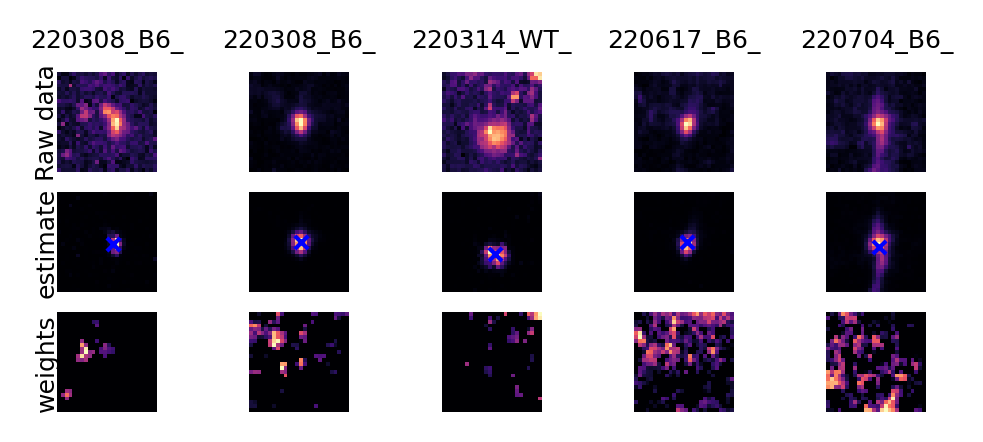

In [120]:
# For each dataset, plot the raw map on the top row,
# then the estimated map on the bottom row, with the COM marked,
# then the summed caviar weights on the bottom row
fig, axs = plt.subplots(3, len(filenames), figsize=(4,1.5), dpi=300, facecolor='white')
from mpl_toolkits.axes_grid1 import make_axes_locatable
for i, (file, results) in enumerate(twod_results.items()):

    # plot raw map on top row
    plt.sca(axs[0, i])
    plt.axis('off')
    plt.imshow(results['raw_map'], cmap='magma', origin='lower')
    plt.title(file[0:10], fontsize=6)

    # label top row as being raw data
    if i == 0:
        plt.text(-0.1, 0.5, 'Raw data', fontsize=6, transform=axs[0, i].transAxes, rotation=90, va='center', ha='center')

    # plot estimated map and COM on bottom row
    com = results['com']
    plt.sca(axs[1, i])
    plt.axis('off')
    plt.imshow(results['est_map'], cmap='magma', origin='lower')
    plt.scatter(com[1], com[0], c='blue', s=10, marker='x', alpha=1.0, linewidths=1)

    # label bottom row as being photocurrent estimate
    if i == 0:
        plt.text(-0.1, 0.5, 'estimate', fontsize=6, transform=axs[1, i].transAxes, rotation=90, va='center', ha='center')

    # plot summed weights on bottom row
    plt.sca(axs[2, i])
    plt.axis('off')
    num_xs = len(np.unique(results['targets'][:,0]))
    num_ys = len(np.unique(results['targets'][:,1]))
    num_zs = len(np.unique(results['targets'][:,2]))

    reshaped_weights = np.reshape(results['weights'], (num_xs, num_ys, num_zs))
    summed_weights = np.sum(reshaped_weights, axis=-1)
    plt.imshow(summed_weights, cmap='magma', origin='lower')

    # label bottom row as being subtracted data
    if i == 0:
        plt.text(-0.1, 0.5, 'weights', fontsize=6, transform=axs[2, i].transAxes, rotation=90, va='center', ha='center')

## sanity check: see if connection probability falls off with distance
Here, we'll just treat each pixel as a cell and see whether connection probability falls off with distance.
For each cell:
1. For each pixel in the weights map shown above, compute the 2D target (in microns) associated with that pixel.
    Can use `scatter(targets[:,0], targets[:,1], c=weights) to verify that these coordinates have been computed correctly.
2. Calculate the number of targeted pixels per distance bin
3. Calculate the number of connected pixels per distance bin
4. Divide (3) by (2) to get connection probability per distance bin

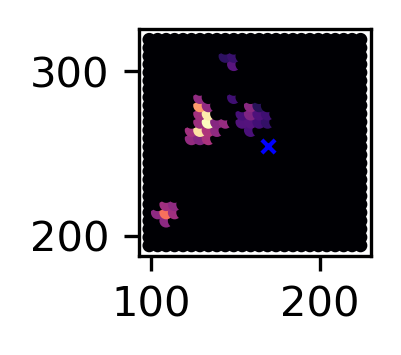

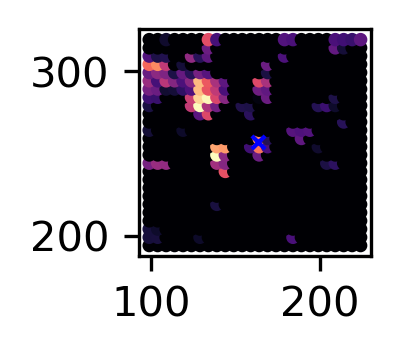

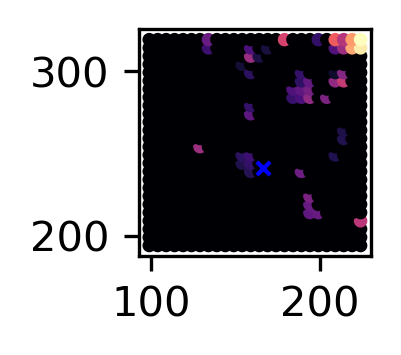

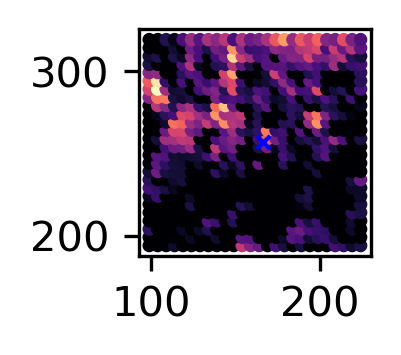

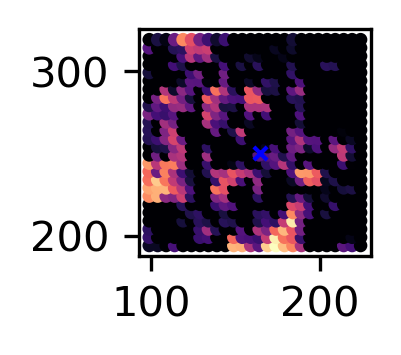

In [106]:
all_connection_dists = np.array([])
all_target_dists = np.array([])

for i, (file, results) in enumerate(twod_results.items()):
    targets = results['targets']
    targets_xy = np.unique(targets[:,0:2], axis=0)
    plt.figure(figsize=(1,1), dpi=300)

    # sum weights over z by folding into a tensor,
    # summing, then unfolding
    num_xs = len(np.unique(results['targets'][:,0]))
    num_ys = len(np.unique(results['targets'][:,1]))
    num_zs = len(np.unique(results['targets'][:,2]))

    reshaped_weights = np.reshape(results['weights'], (num_xs, num_ys, num_zs))
    summed_weights = np.sum(reshaped_weights, axis=-1)
    summed_weights = np.reshape(summed_weights, (-1,))

    plt.scatter(targets_xy[:,1], targets_xy[:,0], c=summed_weights, s=5, alpha=1.0, cmap='magma')
    com_image = index_coords_to_image_coords(results['com'], targets_xy)
    plt.scatter(com_image[1], com_image[0], c='blue', s=10, marker='x', alpha=1.0, linewidths=1)

    targets_dist = np.linalg.norm(targets_xy - com_image, axis=1)
    all_target_dists = np.concatenate((all_target_dists, targets_dist))

    connected_idxs = summed_weights > 0
    connected_targets = targets_xy[connected_idxs]
    connected_dists = np.linalg.norm(connected_targets - com_image, axis=1)
    all_connection_dists = np.concatenate((all_connection_dists, connected_dists))


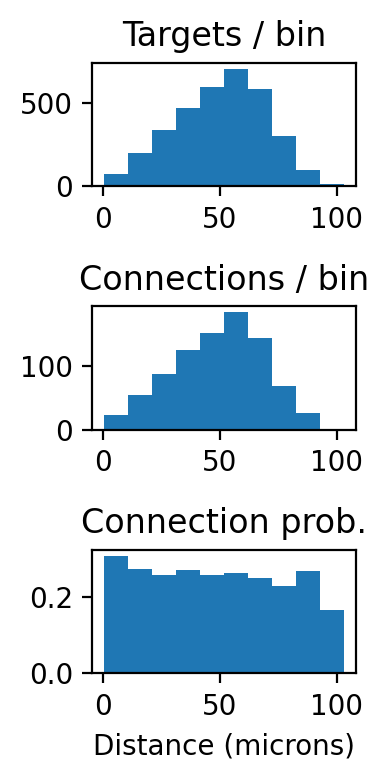

In [114]:
# make 3 histograms:
# 1. connection distances
# 2. target distances
# 3. probability of connection given distance
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(2,4), dpi=200, facecolor='white')

n_targets, bins, patches = axs[0].hist(all_target_dists, bins=10)
axs[0].set_title('Targets / bin')

n_connections, bins, patches = axs[1].hist(all_connection_dists, bins=bins)
axs[1].set_title('Connections / bin')

connection_probs = n_connections / n_targets
axs[2].hist(bins[:-1], bins, weights=connection_probs)
axs[2].set_title('Connection prob.')
axs[2].set_xlabel('Distance (microns)')
plt.tight_layout()


In [52]:
bins

array([200.49878503, 219.00587067, 237.5129563 , 256.02004193,
       274.52712756, 293.0342132 , 311.54129883, 330.04838446,
       348.55547009, 367.06255572, 385.56964136])